<a href="https://colab.research.google.com/github/arthurnicolas59/BloodCellDec22---DataScientest/blob/Ludo/Blood_Cell_Segmentation_et_classification_mod%C3%A8le_UNET.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **1. Connexion au Drive, activation du GPU, import des images**


## 1.1. Activation du GPU



In [ ]:
import tensorflow as tf
if tf.test.gpu_device_name():
    print('Default GPU Device:{}'.format(tf.test.gpu_device_name()))
else:
    print("Please change your hardware accelerator")

Default GPU Device:/device:GPU:0


In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


## 1.2. Import des images (Barcelone)



In [ ]:
!unzip 'drive/MyDrive/Datascientest/PBC_dataset_normal_DIB.zip'

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
  inflating: PBC_dataset_normal_DIB/erythroblast/ERB_292483.jpg  
  inflating: PBC_dataset_normal_DIB/erythroblast/ERB_935950.jpg  
  inflating: PBC_dataset_normal_DIB/erythroblast/ERB_890863.jpg  
  inflating: PBC_dataset_normal_DIB/erythroblast/ERB_519370.jpg  
  inflating: PBC_dataset_normal_DIB/erythroblast/ERB_215077.jpg  
  inflating: PBC_dataset_normal_DIB/erythroblast/ERB_388154.jpg  
  inflating: PBC_dataset_normal_DIB/erythroblast/ERB_968896.jpg  
  inflating: PBC_dataset_normal_DIB/erythroblast/ERB_34345.jpg  
  inflating: PBC_dataset_normal_DIB/erythroblast/ERB_349907.jpg  
  inflating: PBC_dataset_normal_DIB/erythroblast/ERB_245683.jpg  
  inflating: PBC_dataset_normal_DIB/erythroblast/ERB_785122.jpg  
  inflating: PBC_dataset_normal_DIB/erythroblast/ERB_615525.jpg  
  inflating: PBC_dataset_normal_DIB/erythroblast/ERB_714613.jpg  
  inflating: PBC_dataset_normal_DIB/erythroblast/ERB_904757.jpg  

In [ ]:
# suppression d'une image présentant un défaut de format :
import os

os.remove('/content/PBC_dataset_normal_DIB/neutrophil/.DS_169665.jpg')

# **2. Création du dataframe 'df' identifiant le chemin d'accès de chaque image et son label**

In [ ]:
import glob
import pandas as pd

# Trouver tous les chemins vers les fichiers qui finissent par .jpg
liste = glob.glob('./PBC_dataset_normal_DIB/*/*.jpg')

# Création d'une liste comprenant les chemins d'accès aux images ainsi que le label de chaque image
liste = list(map(lambda x : [x, x.split('/')[3].split('_')[0]], liste))

# Créer un DataFrame pandas
df = pd.DataFrame(liste, columns=['filepath', 'nameLabel'])
df=df.replace(['SNE','BNE'],'NEUTROPHIL')
df=df.replace(['MY','MMY','PMY'],'IG')
df['label'] = df['nameLabel'].replace(df.nameLabel.unique(), [*range(len(df.nameLabel.unique()))])
df.sort_values('filepath')
df

,filepath,nameLabel,label
0,./PBC_dataset_normal_DIB/ig/MMY_167107.jpg,IG,0
1,./PBC_dataset_normal_DIB/ig/MY_82522.jpg,IG,0
2,./PBC_dataset_normal_DIB/ig/IG_742024.jpg,IG,0
3,./PBC_dataset_normal_DIB/ig/MY_286474.jpg,IG,0
4,./PBC_dataset_normal_DIB/ig/MY_317446.jpg,IG,0
...,...,...,...
17087,./PBC_dataset_normal_DIB/monocyte/MO_826797.jpg,MO,7
17088,./PBC_dataset_normal_DIB/monocyte/MO_762364.jpg,MO,7
17089,./PBC_dataset_normal_DIB/monocyte/MO_399228.jpg,MO,7
17090,./PBC_dataset_normal_DIB/monocyte/MO_312237.jpg,MO,7


## 2.1. Information sur le dataset



In [ ]:
# shape
df.nameLabel.unique()
df.shape

(17092, 3)

In [ ]:
# répartition du nombre d'images selon le label
df.nameLabel.value_counts()

NEUTROPHIL    3329
EO            3117
IG            2895
PLATELET      2348
ERB           1551
MO            1420
BA            1218
LY            1214
Name: nameLabel, dtype: int64

# **3. Création du dataframe 'df_mask' présentant le chemin d'accès des images segmentées issues du modèle SAM et des images sources correspondantes**

In [ ]:
#### Import des 4502 images précédemment segmentées et sauvegardées dans la partie 3.
!unzip 'drive/MyDrive/Datascientest/masques-19072023.zip'

Archive:  drive/MyDrive/Datascientest/masques-19072023.zip
  inflating: masques/eosinophil/EO_197212_mask.png  
  inflating: masques/eosinophil/EO_424918_mask.png  
  inflating: masques/eosinophil/EO_406215_mask.png  
  inflating: masques/eosinophil/EO_209028_mask.png  
  inflating: masques/eosinophil/EO_324141_mask.png  
  inflating: masques/eosinophil/EO_351942_mask.png  
  inflating: masques/eosinophil/EO_578965_mask.png  
  inflating: masques/eosinophil/EO_841216_mask.png  
  inflating: masques/eosinophil/EO_910_mask.png  
  inflating: masques/eosinophil/EO_485946_mask.png  
  inflating: masques/eosinophil/EO_989530_mask.png  
  inflating: masques/eosinophil/EO_345129_mask.png  
  inflating: masques/eosinophil/EO_661288_mask.png  
  inflating: masques/eosinophil/EO_220964_mask.png  
  inflating: masques/eosinophil/EO_666039_mask.png  
  inflating: masques/lymphocyte/LY_35661_mask.png  
  inflating: masques/eosinophil/EO_872946_mask.png  
  inflating: masques/eosinophil/EO_726217_ma

In [ ]:
# Trouver tous les chemins vers les fichiers qui finissent par .png
liste_mask = glob.glob('/content/masques/*/*.png')

# # Création d'une liste comprenant les chemins d'accès aux images ainsi que le label de chaque image
liste_mask = list(map(lambda x : [x,
                                  x.split('/')[4].split('_')[0],
                                  '/content/PBC_dataset_normal_DIB/'+x.split('/')[3]+'/'+ x.split('/')[4].split('_')[0]+'_'+x.split('/')[4].split('_')[1]+'.jpg'],
                       liste_mask))

# Créer un DataFrame pandas
df_mask = pd.DataFrame(liste_mask, columns=['maskpath', 'nameLabel','filepath'])
df_mask=df_mask.replace(['SNE','BNE'],'NEUTROPHIL')
df_mask=df_mask.replace(['MY','MMY','PMY'],'IG')
# df_mask['label'] = df['nameLabel'].replace(df_mask.nameLabel.unique(), [*range(len(df_mask.nameLabel.unique()))])
df_mask.sort_values('maskpath')
df_mask

,maskpath,nameLabel,filepath,label
0,/content/masques/ig/MY_951641_mask.png,IG,/content/PBC_dataset_normal_DIB/ig/MY_951641.jpg,0
1,/content/masques/ig/PMY_428070_mask.png,IG,/content/PBC_dataset_normal_DIB/ig/PMY_428070.jpg,0
2,/content/masques/ig/MMY_279784_mask.png,IG,/content/PBC_dataset_normal_DIB/ig/MMY_279784.jpg,0
3,/content/masques/ig/MY_406693_mask.png,IG,/content/PBC_dataset_normal_DIB/ig/MY_406693.jpg,0
4,/content/masques/ig/IG_79498_mask.png,IG,/content/PBC_dataset_normal_DIB/ig/IG_79498.jpg,0
...,...,...,...,...
4497,/content/masques/monocyte/MO_12336_mask.png,MO,/content/PBC_dataset_normal_DIB/monocyte/MO_12...,2
4498,/content/masques/monocyte/MO_994944_mask.png,MO,/content/PBC_dataset_normal_DIB/monocyte/MO_99...,2
4499,/content/masques/monocyte/MO_618817_mask.png,MO,/content/PBC_dataset_normal_DIB/monocyte/MO_61...,2
4500,/content/masques/monocyte/MO_149989_mask.png,MO,/content/PBC_dataset_normal_DIB/monocyte/MO_14...,2


##4.1. Information sur le dataset des 4502 images segmentées

In [ ]:
# répartition du nombre d'images selon le label dans le dataframe df_mask
df_mask.nameLabel.value_counts()

BA            756
MO            721
LY            688
ERB           503
PLATELET      499
EO            455
NEUTROPHIL    443
IG            437
Name: nameLabel, dtype: int64

# **4. Création d'un dataframe comprenant l'ensemble des images originales qui n'ont pas été segmentées par le modèle SAM.**



In [ ]:
# copie de df_mask et de df
df_mask2=df_mask
df2=df

In [ ]:
# modification de la variable 'filepath' de df2 pour qu'elle corresponde exactement à celle de df_mask2
df2['filepath']='/content'+df['filepath'].str[1:]

In [ ]:
# Concaténation des dataframe df_mask2 et df2
union=pd.concat([df_mask2,df2],axis=0)

In [ ]:
# Suppression des doublons repérés dans la colonne filepath, supprimant ainsi les lignes de df2 qui ont fait l'objet de la création d'une segmentation et que l'on retrouve dans df_mask2
union.drop_duplicates(subset=['filepath'],inplace=True)

In [ ]:
# Remplacement des valeurs nulles du nouveau dataframe, qui correspondent aux images qui n'ont pas été segmentées. Création d'un nouveau dataframe
union2 = union.fillna('key')

In [ ]:
# Création du dataframe final, comprenant uniquement les chemins des d'accès des images n'ayant pas été segmentées
df_img_sans_masque=union2.loc[union2['maskpath']=='key']

In [ ]:
# Affichage de ce nouveau dataframe
df_img_sans_masque

,maskpath,nameLabel,filepath,label
0,key,NEUTROPHIL,/content/PBC_dataset_normal_DIB/neutrophil/SNE...,0.0
1,key,NEUTROPHIL,/content/PBC_dataset_normal_DIB/neutrophil/BNE...,0.0
2,key,NEUTROPHIL,/content/PBC_dataset_normal_DIB/neutrophil/SNE...,0.0
4,key,NEUTROPHIL,/content/PBC_dataset_normal_DIB/neutrophil/BNE...,0.0
5,key,NEUTROPHIL,/content/PBC_dataset_normal_DIB/neutrophil/BNE...,0.0
...,...,...,...,...
17081,key,BA,/content/PBC_dataset_normal_DIB/basophil/BA_18...,7.0
17082,key,BA,/content/PBC_dataset_normal_DIB/basophil/BA_69...,7.0
17085,key,BA,/content/PBC_dataset_normal_DIB/basophil/BA_70...,7.0
17086,key,BA,/content/PBC_dataset_normal_DIB/basophil/BA_93...,7.0


# **5. Création de MASQUES en utilisant le modèle Unet**

## **5.1. Préparation des images et des masques issues de la Segmentation SAM**

Transformation des images segmentées par le modèle SAM en masques, exploitables par le Modèle UNET.

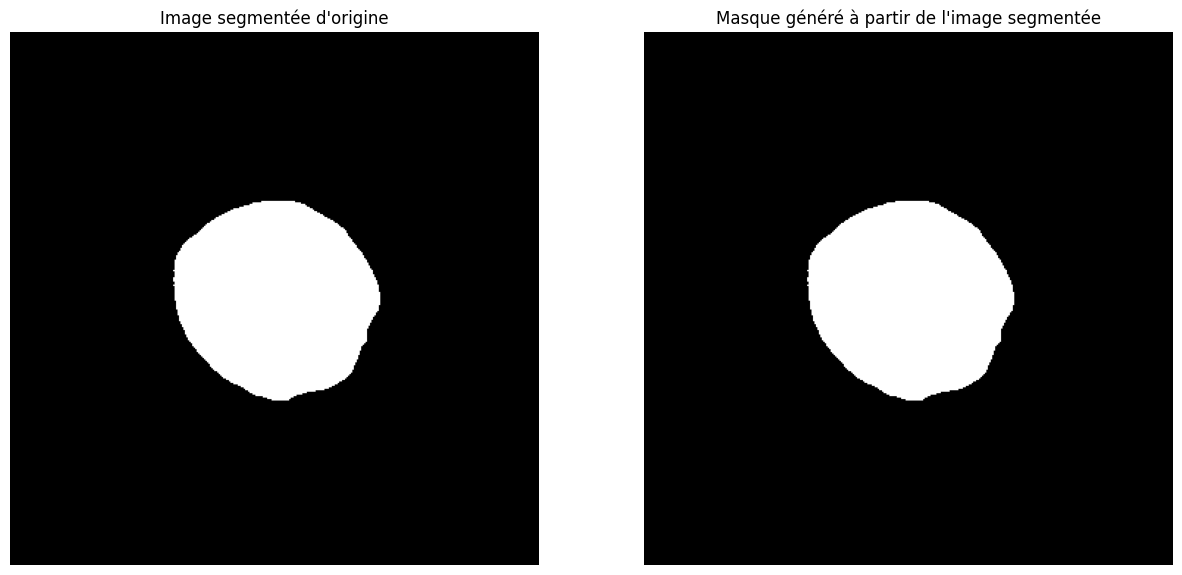

In [ ]:
import matplotlib.pyplot as plt
import cv2

### Génération de masques à partir des images segmentées du jeu de données

### Premièrement, on récupère les chemins des dossiers contenant les images

path_folders=glob.glob('/content/masques/**')

### Affichage d'un exemple d'image segmentée

path_example= glob.glob(path_folders[0]+'/**')[0]
plt.figure(figsize=(15,7))
plt.subplot(121)
example=cv2.imread(path_example)
plt.imshow(example)
plt.title("Image segmentée d'origine")
plt.axis('off')

### Transformation des images segmentées en masques

threshold=20
for path in path_folders:
  for fichier in glob.glob(path+'/**'):
      img=cv2.imread(fichier)
      if len(img.shape)==3:

        ### La moyenne des pixels RGB est calculée et un seuil est défini pour séparer les pixels
        ### de la feuille et le reste.
        ### La valeur de 1 est attribué pour un pixel de la feuille, le pixel prend la valeur 0 sinon.

          img_mask=(img.mean(axis=2)>threshold).astype(int)
          cv2.imwrite(fichier,img_mask)

### Exemple de masque produit

plt.subplot(122)
example=cv2.imread(path_example,cv2.IMREAD_GRAYSCALE)
plt.imshow(example*255,cmap='gray')
plt.title("Masque généré à partir de l'image segmentée")
plt.axis('off');

## **5.2. Instanciation du modèle UNET générateur de masques**

Créer l'architecture du modèle.

In [ ]:
### Import des modules nécessaires pour l'ensemble du travail

import numpy as np
import os
import glob
import cv2
from keras import callbacks
import pandas as pd
import skimage.io as io
import skimage.transform as trans
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as keras
from sklearn.preprocessing import LabelEncoder

In [ ]:
### Définition de la structure du modèle avec ses différentes couches

def unet(input_size = (256,256,3)):
    inputs = Input(input_size)
    conv1 = Conv2D(32, 3, activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, 3, activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=2)(conv1)

    conv2 = Conv2D(64, 3, activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, 3, activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2))(conv2)

    conv3 = Conv2D(128, 3, activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, 3, activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2))(conv3)

    conv4 = Conv2D(256, 3, activation='relu', padding='same')(pool3)
    conv4 = Conv2D(256, 3, activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2))(conv4)

    conv5 = Conv2D(512, 3, activation='relu', padding='same')(pool4)
    conv5 = Conv2D(512, 3, activation='relu', padding='same')(conv5)

    up6 = concatenate([UpSampling2D(size=(2))(conv5), conv4], axis=-1)
    conv6 = Conv2D(256, 3, activation='relu', padding='same')(up6)
    conv6 = Conv2D(256, 3, activation='relu', padding='same')(conv6)

    up7 = concatenate([UpSampling2D(size=(2))(conv6), conv3], axis=-1)
    conv7 = Conv2D(128, 3, activation='relu', padding='same')(up7)
    conv7 = Conv2D(128, 3, activation='relu', padding='same')(conv7)

    up8 = concatenate([UpSampling2D(size=(2))(conv7), conv2], axis=-1)
    conv8 = Conv2D(64, 3, activation='relu', padding='same')(up8)
    conv8 = Conv2D(64, 3, activation='relu', padding='same')(conv8)

    up9 = concatenate([UpSampling2D(size=(2))(conv8), conv1], axis=-1)
    conv9 = Conv2D(32, (3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(32, (3), activation='relu', padding='same')(conv9)

    conv10 = Conv2D(1, 1, activation='sigmoid')(conv9)

    # Ajouter des couches de classification
    flatten_layer = Flatten()(conv10)
    dense1 = Dense(64, activation='relu')(flatten_layer)
    dense2 = Dense(8, activation='softmax')(dense1)  # 8 classes de classification

    # Créer le modèle complet
    model_with_classification = Model(inputs=inputs, outputs=[conv10, dense2])
    model_with_classification.summary()

    return model_with_classification



In [ ]:
model_with_classification = unet(input_size=(256, 256, 3))

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 32  896         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 256, 256, 32  9248        ['conv2d[0][0]']                 
                                )                                                             

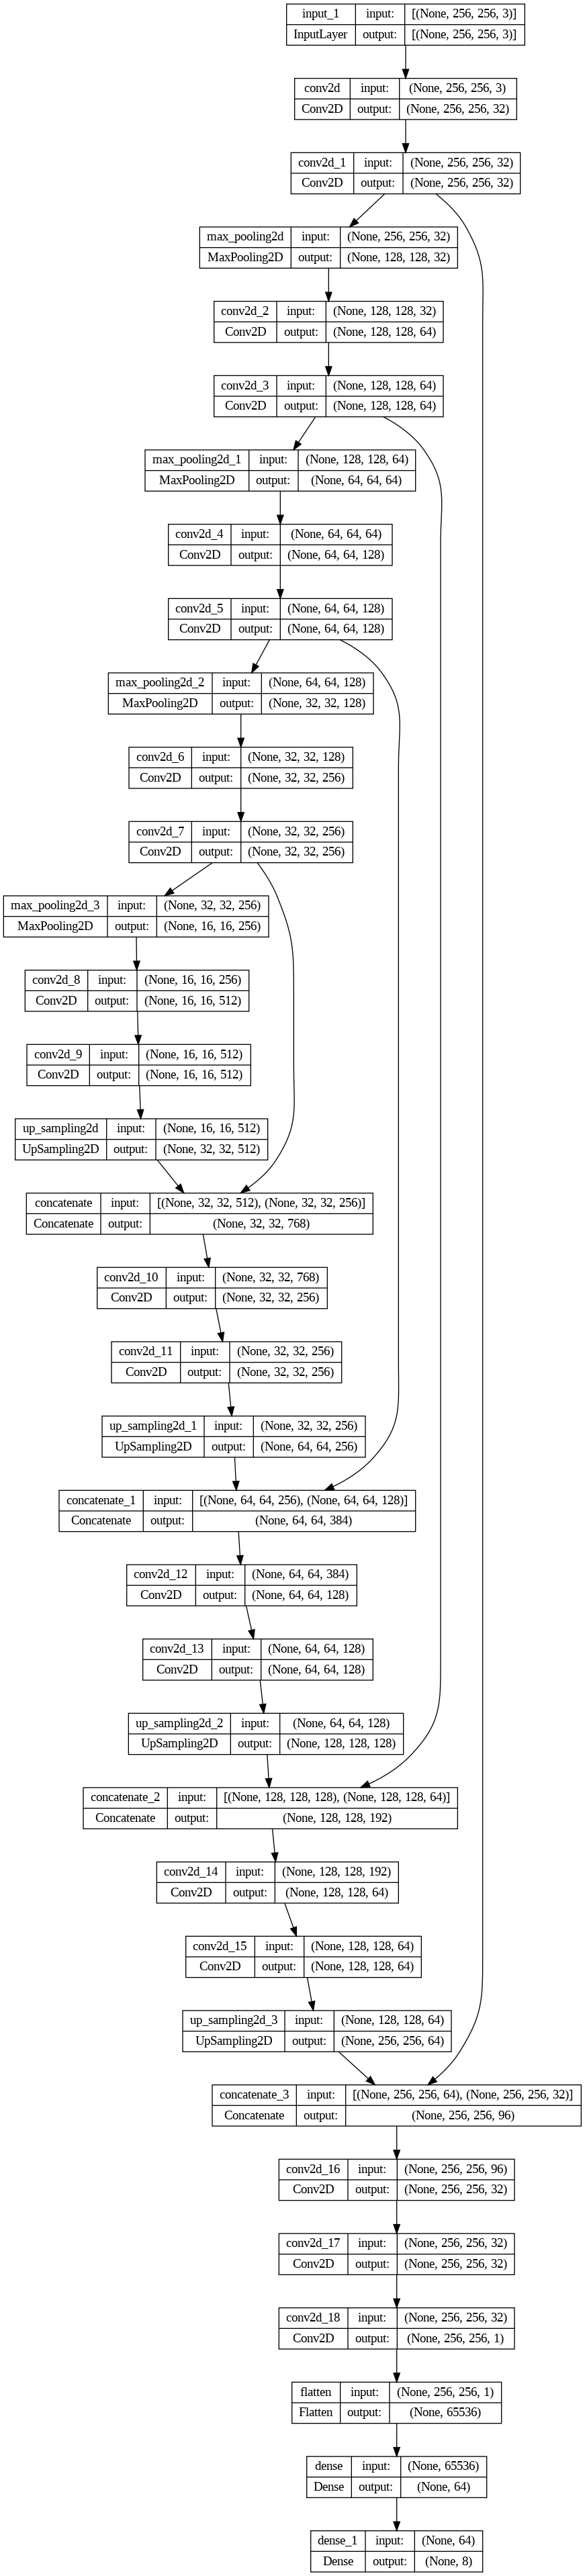

In [ ]:
from tensorflow.keras.utils import plot_model
from keras.layers import Dense, Flatten
# structure des modèles


plot_model(model_with_classification, show_shapes=True)

## **5.3. Définition de la fonction de perte et des métriques**

In [ ]:

def Loss_mask(y_true, y_pred):
    y_true_segmentation = y_true[0]
    y_pred_segmentation = y_pred[0]
    return tf.keras.losses.binary_crossentropy(y_true_segmentation, y_pred_segmentation)

def Loss_classification(y_true, y_pred):
    y_true_classification = tf.squeeze(y_true[1]) # S'assurer que c'est un vecteur 1D
    y_pred_classification = y_pred[1]
    return tf.keras.losses.SparseCategoricalCrossentropy()(y_true_classification, y_pred_classification)




### Définition des métriques
def metric_mask(y_true, y_pred):
    true_mask = y_true[0]
    pred_mask = y_pred[0]
    return tf.keras.metrics.binary_accuracy(true_mask, pred_mask)

def metric_classification(y_true, y_pred):
    y_true_classification = y_true[1]
    y_pred_classification = y_pred[1]
    return tf.keras.metrics.sparse_categorical_accuracy(y_true_classification, y_pred_classification)



## **5.4. Compilation du modèle**

In [ ]:


model_with_classification.compile(
    optimizer='adam',
    loss={
        'conv2d_18': 'binary_crossentropy',  # Nom de la couche de segmentation
        'dense_1': 'categorical_crossentropy'  # Nom de la couche de classification
    },
    loss_weights=[1., 1.],
    metrics={'conv2d_18': 'accuracy', 'dense_1': 'accuracy'}  # Ajouter des métriques si nécessaire
)



## **5.5. Préparation et chargement du jeu de données**

In [ ]:
### Création du jeu d'entrainement, de validation et de test

height=256
width=256
batch_size=32
seed=12

# Diviser les données en ensembles d'entraînement, de validation et de test
X_train_path, X_test_path, y_train_path, y_test_path,y_train_labels,y_test_labels = train_test_split(df_mask.filepath, df_mask.maskpath,df_mask.nameLabel, test_size=0.2, random_state=456)

X_train_path, X_val_path, y_train_path, y_val_path,y_train_labels,y_val_labels = train_test_split(X_train_path, y_train_path,y_train_labels, test_size=0.2, random_state=456)

# Créez une instance de LabelEncoder
label_encoder = LabelEncoder()

# Fit sur les étiquettes de classification existantes pour obtenir la correspondance
label_encoder.fit(y_train_labels)

# Transformez les étiquettes de classification en nombres entiers
y_train_labels = label_encoder.transform(y_train_labels)
y_val_labels = label_encoder.transform(y_val_labels)
y_test_labels = label_encoder.transform(y_test_labels)

# Maintenant, y_train_encoded, y_val_encoded et y_test_encoded contiennent les étiquettes
# de classification sous forme de nombres entiers

# Créer des datasets à partir des chemins d'accès et des labels
dataset_train = tf.data.Dataset.from_tensor_slices((X_train_path, y_train_path, y_train_labels))

dataset_val = tf.data.Dataset.from_tensor_slices((X_val_path, y_val_path, y_val_labels))

dataset_test =tf.data.Dataset.from_tensor_slices((X_test_path, y_test_path, y_test_labels))

from tensorflow.keras.utils import to_categorical

y_train_labels_one_hot = to_categorical(y_train_labels, num_classes=8)
y_val_labels_one_hot = to_categorical(y_val_labels, num_classes=8)


def load_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [height, width])
    return image

def load_mask(mask_path):
    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_jpeg(mask, channels=1)
    mask = tf.image.resize(mask, [height, width])
    return mask

def load_data(image_path, mask_path, label):
    # Charger l'image et le masque comme précédemment
    image = load_image(image_path)
    mask = load_mask(mask_path)

    # Utilisez une représentation one-hot pour les étiquettes
    label_one_hot = tf.one_hot(label, depth=8)

    return image, (mask, label_one_hot)

def load_images_and_masks(image_paths, mask_paths):
    images = [load_image(path).numpy() for path in image_paths]
    masks = [load_mask(path).numpy() for path in mask_paths]
    return np.array(images), np.array(masks)

X_train_images, y_train_masks = load_images_and_masks(X_train_path, y_train_path)
X_val_images, y_val_masks = load_images_and_masks(X_val_path, y_val_path)


# Appliquer la fonction load_data aux datasets
dataset_train = dataset_train.map(load_data, num_parallel_calls=tf.data.AUTOTUNE)


# Print shape before batching
for image, (mask, label) in dataset_train.take(1): # Modifiez cette ligne
    print("Image shape before batching:", image.shape)
    print("Mask shape before batching:", mask.shape)
    print("Label shape before batching:", label.shape)

dataset_train = dataset_train.batch(batch_size, drop_remainder=True)

# Print shape after batching
for image, (mask, label) in dataset_train.take(1): # Modifiez cette ligne
    print("Image shape after batching:", image.shape)
    print("Mask shape after batching:", mask.shape)
    print("Label shape after batching:", label.shape)

dataset_val = dataset_val.map(load_data, num_parallel_calls=tf.data.AUTOTUNE)

# Print shape before batching
for image, (mask, label) in dataset_val.take(1): # Modifiez cette ligne
    print("Image shape before batching:", image.shape)
    print("Mask shape before batching:", mask.shape)
    print("Label shape before batching:", label.shape)

dataset_val = dataset_val.batch(batch_size, drop_remainder=True)

# Print shape after batching
for image, (mask, label) in dataset_val.take(1): # Modifiez cette ligne
    print("Image shape after batching:", image.shape)
    print("Mask shape after batching:", mask.shape)
    print("Label shape after batching:", label.shape)

dataset_test = dataset_test.map(load_data, num_parallel_calls=tf.data.AUTOTUNE)

# Print shape before batching
for image, (mask, label) in dataset_test.take(1): # Modifiez cette ligne
    print("Image shape before batching:", image.shape)
    print("Mask shape before batching:", mask.shape)
    print("Label shape before batching:", label.shape)

dataset_test = dataset_test.batch(batch_size, drop_remainder=True)

# Print shape after batching
for image, (mask, label) in dataset_test.take(1): # Modifiez cette ligne
    print("Image shape after batching:", image.shape)
    print("Mask shape after batching:", mask.shape)
    print("Label shape after batching:", label.shape)


### Augmentation des données

def create_generators(image_paths, mask_paths, labels_one_hot, batch_size):
    # Charger les images et masques
    images, masks = load_images_and_masks(image_paths, mask_paths)

    # Convertir les labels en tableaux NumPy
    labels = np.array(labels_one_hot)

    # Créer ImageDataGenerator pour les images et masques
    image_datagen = ImageDataGenerator(
        rotation_range=10,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=True
    )
    mask_datagen = ImageDataGenerator(
        rotation_range=10,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=True
    )

    # Fit les générateurs sur les données
    image_datagen.fit(images, augment=True, seed=42)
    mask_datagen.fit(masks, augment=True, seed=42)

    # Créer les générateurs
    image_generator = image_datagen.flow(images, batch_size=batch_size, seed=42)
    mask_generator = mask_datagen.flow(masks, batch_size=batch_size, seed=42)

    # Associer les images, masques et labels
    while True:
        img_batch = image_generator.next()
        mask_batch = mask_generator.next()
        idx = (image_generator.batch_index - 1) * batch_size
        label_batch = labels_one_hot[idx: idx + batch_size]
        yield img_batch, [mask_batch, label_batch]




train_generator = create_generators(X_train_path, y_train_path, y_train_labels_one_hot, batch_size)
val_generator = create_generators(X_val_path, y_val_path, y_val_labels_one_hot, batch_size)






Image shape before batching: (256, 256, 3)
Mask shape before batching: (256, 256, 1)
Label shape before batching: (8,)
Image shape after batching: (32, 256, 256, 3)
Mask shape after batching: (32, 256, 256, 1)
Label shape after batching: (32, 8)
Image shape before batching: (256, 256, 3)
Mask shape before batching: (256, 256, 1)
Label shape before batching: (8,)
Image shape after batching: (32, 256, 256, 3)
Mask shape after batching: (32, 256, 256, 1)
Label shape after batching: (32, 8)
Image shape before batching: (256, 256, 3)
Mask shape before batching: (256, 256, 1)
Label shape before batching: (8,)
Image shape after batching: (32, 256, 256, 3)
Mask shape after batching: (32, 256, 256, 1)
Label shape after batching: (32, 8)


Vérification du format des données

In [ ]:
import numpy as np

print("Shape of y_train_labels:", np.shape(y_train_labels))
print("Shape of y_val_labels:", np.shape(y_val_labels))
print("Shape of y_test_labels:", np.shape(y_test_labels))


Shape of y_train_labels: (2880,)
Shape of y_val_labels: (721,)
Shape of y_test_labels: (901,)


In [ ]:
print(y_train_labels[:10])  # Affiche les 10 premières étiquettes d'entraînement
print(y_val_labels[:10])

[0 1 6 0 3 7 4 2 6 4]
[2 7 7 7 5 5 7 0 4 3]


## **5.6. Définition de callbacks et entrainement du modèle**

In [ ]:
### Définition de callbacks et entrainement du modèle

### Sauvegarde automatique des poids
checkpoint = callbacks.ModelCheckpoint(filepath = '/content/drive/MyDrive/weights_Unet_Seg_Class.h5',
                                       monitor = 'loss',
                                       save_best_only = True,
                                       save_weights_only = True,
                                       mode = 'min',
                                       save_freq = 'epoch')

### 'Callback' permettant d'ajuster le taux d'apprentissage au cours de l'entrainement
lr_plateau = callbacks.ReduceLROnPlateau(monitor = 'loss',
                                         patience=1,
                                         factor=0.1,
                                         verbose=2,
                                         mode='min')

## **5.7. Entraînement du modèle**

In [ ]:
training=model_with_classification.fit(train_generator, epochs=3, validation_data=val_generator, callbacks = [lr_plateau, checkpoint])

In [ ]:
### Sauvegarde des poids et du modèle entrainé
export_dir='/content/drive/MyDrive/'
model_with_classification.save_weights(export_dir+'weights_model_with_classification.h5')
model_with_classification.save(export_dir+'model_with_classification.h5')


## **5.8. Evaluation de la précision du modèle UNET et réalisation d'essais sur de nouvelles images**

Le modèle est évalué sur le jeu de donnée de test et des images d'un autre jeu de données vont être chargées pour pouvoir tester la segmentation générée.

In [ ]:
### Evaluation de la précision du modèle sur le jeu de test
evaluation=model_with_classification.evaluate(dataset_test)
print('Précision du modèle sur le jeu de test :',np.round(evaluation[1],2),"\n",
      'Perte du modèle sur le jeu de test :',np.round(evaluation[0],2))

28/28 [==============================] - 5s 160ms/step - loss: 1.2014 - conv2d_18_loss: 0.2442 - dense_1_loss: 0.9572 - conv2d_18_accuracy: 0.9023 - dense_1_accuracy: 0.6808
Précision du modèle sur le jeu de test : 0.24 
 Perte du modèle sur le jeu de test : 1.2


1/1 [==============================] - 0s 177ms/step


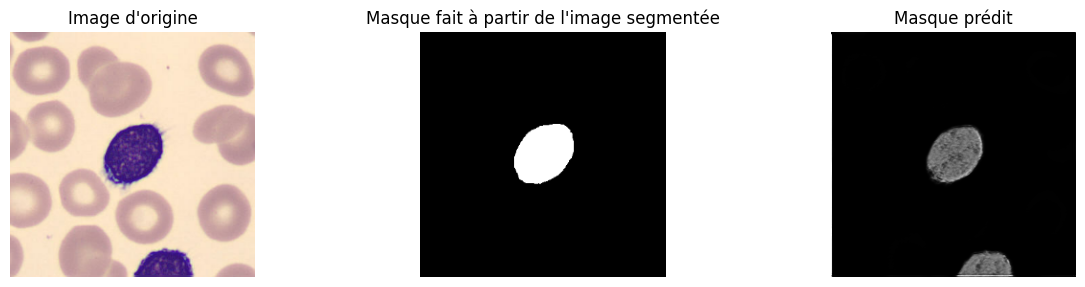

1/1 [==============================] - 0s 21ms/step


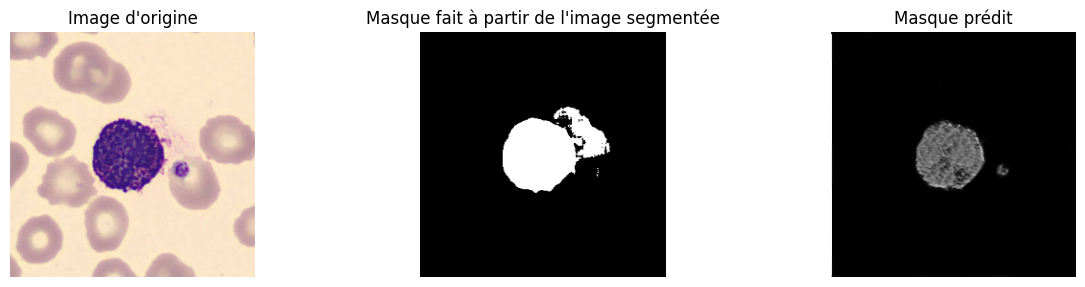

In [ ]:
intermediate_model = Model(inputs=model_with_classification.input, outputs=model_with_classification.get_layer('conv2d_18').output)


### Démonstration d'une prédiction de masque en comparaison avec un masque
### fait à partir de l'image segmentée du jeu de donnée Test

size=2
indexes=np.random.choice(np.array(X_test_path.index),size=2)

i=0
for idx in indexes:
  image=load_image(X_test_path[idx])
  img=tf.reshape(image,(1,256,256,3))
  mask_pred=model_with_classification.predict(img)
  mask_true=load_mask(y_test_path[idx])
  image=tf.cast(image,dtype=tf.int32)

  plt.figure(figsize=(15,7))

  i+=1
  plt.subplot(size,3,i)
  plt.imshow(image)
  plt.axis("off")
  plt.title("Image d'origine")

  i+=1
  plt.subplot(size,3,i)
  plt.imshow(tf.reshape(mask_true,(256,256)),cmap='gray')
  plt.axis("off")
  plt.title("Masque fait à partir de l'image segmentée")


  # Prédire le masque pour une entrée de votre choix
  input_data = img  # Votre données d'entrée ici
  mask_pred = intermediate_model.predict(input_data)

  i+=1
  plt.subplot(size,3,i)
  plt.imshow(mask_pred[0, :, :, 0],cmap='gray')
  plt.axis('off')
  plt.title("Masque prédit")
  plt.show()





# Afficher le masque
# plt.imshow(mask_pred[0, :, :, 0], cmap='gray')
# plt.axis('off')
# plt.show()